In [1]:
import numpy as np
import wisps
import wisps.simulations as wispsim
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm 
import pandas as pd
import matplotlib as mpl
import wisps.simulations.effective_numbers as eff
import astropy.coordinates as astrocoord
%matplotlib inline
import splat

In [2]:
#wispsim.make_pointings()

In [3]:
from wisps import drop_nan

In [4]:
baraffe_data=eff.simulation_outputs()["baraffe2003"]
saumon_data=eff.simulation_outputs()["saumon2008"]


In [5]:
import seaborn as sns

In [6]:
cmap_teff=sns.diverging_palette(100, 300, s=80, l=55, n=19, as_cmap=True)

In [7]:
#older_pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_corrected.pkl')
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_uncorrected.pkl')

pnts110=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
pnts140=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf140.pkl')
pnts160=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf160.pkl')

In [8]:
def bin_volumes(pnts):
    volumes=[]
    dlimits=[]
    for pnt in pnts:
        vs=[]
        dls=[]
        for g in wispsim.SPGRID:
            vsx=[]
            for h in wispsim.HS:
                vsx.append((pnt.volumes[h])[g])
            dls.append(pnt.dist_limits[g])
            vs.append(vsx)
        volumes.append(vs)
        dlimits.append(dls)
    volumes=np.array(volumes)
    dlimits=np.array(dlimits)
    
    return  volumes, dlimits

In [9]:
volumes110, _ =bin_volumes(pnts110)
oldervolumes, olderdlimits=bin_volumes(pnts)
volumes140, _=bin_volumes(pnts140)
volumes160, _=bin_volumes(pnts160)

In [10]:
#fig = plt.figure(figsize=(8,5))
#ax = fig.add_subplot(111, projection="mollweide")
#c=ax.scatter(galc.l.wrap_at(180*u.degree).radian,galc.b.wrap_at(90*u.degree).radian, marker='+', cmap='viridis')
#ax.set_xlabel('l (deg)', fontsize=18)
#ax.set_ylabel('b (deg)', fontsize=18)
#plt.grid()
#plt.savefig(wisps.OUTPUT_FIGURES+'/fields_skymap.pdf', bbox_inches='tight')

In [11]:
from matplotlib.colors import Normalize


In [12]:
from scipy import integrate

In [13]:
volume_fx=np.vectorize(wispsim.custom_volume)

In [14]:
import seaborn as sns
import matplotlib
#cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
cmap=matplotlib.cm.get_cmap('coolwarm')
cnorm=Normalize(wispsim.HS[0]/100, (wispsim.HS[-1])/100)

8it [00:04,  1.82it/s]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


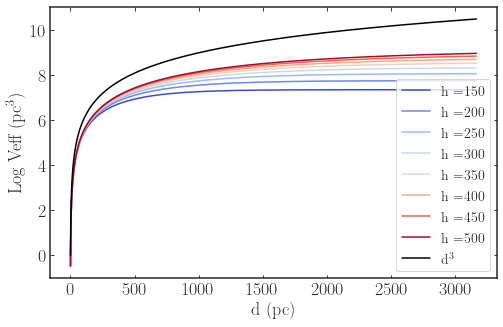

In [15]:
ds=np.logspace(0, 3.5, 1000)
fig, ax=plt.subplots(figsize=(8, 5))
for idx, h in tqdm(enumerate(wispsim.HS)):
    plt.plot(ds, np.log10(volume_fx(0.,np.pi/4, 0, ds,h)), color=cmap(cnorm(h/100)), label=r'h ={}'.format(h))
plt.plot(ds, np.log10(ds**3), c='k', label=r'd$^3$')
plt.ylabel(r'Log Veff (pc$^3$)', fontsize=18)
plt.xlabel('d (pc)', fontsize=18)
plt.legend(fontsize=14)

In [16]:
VOLUMESF110=np.nansum(volumes110.T, axis=2)*4.1*(u.arcmin**2).to(u.radian**2)
OLDERVOLUMES=np.nansum(oldervolumes.T, axis=2)*4.1*(u.arcmin**2).to(u.radian**2)
VOLUMESF140=np.nansum(volumes140.T, axis=2)*4.1*(u.arcmin**2).to(u.radian**2)
VOLUMESF160=np.nansum(volumes160.T, axis=2)*4.1*(u.arcmin**2).to(u.radian**2)

In [17]:
median_volumes= np.nanmean([VOLUMESF140, VOLUMESF160, VOLUMESF110], axis=0)

In [18]:
h=500

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


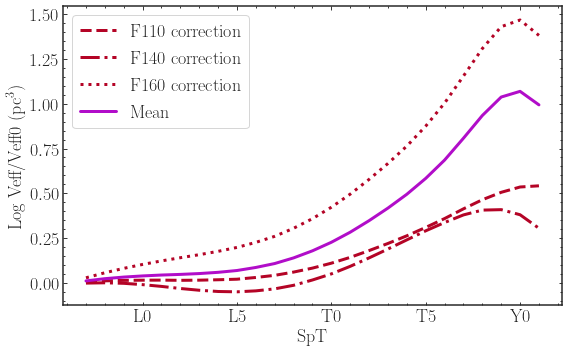

In [19]:
fig, ax=plt.subplots(figsize=(8, 5))
#for idx, h in enumerate(wispsim.HS):
plt.plot(wispsim.SPGRID, np.log10(VOLUMESF110[-1]/OLDERVOLUMES[-1]), color=cmap(cnorm(h/100)),
         label='F110 correction', linewidth=3, linestyle='--')
    
#plt.plot(wispsim.SPGRID, np.log10(OLDERVOLUMES[-1]), color=cmap(cnorm(h/100)),
#          linewidth=3, linestyle='-', label='No correction')

    
plt.plot(wispsim.SPGRID, np.log10(VOLUMESF140[-1]/OLDERVOLUMES[-1]), color=cmap(cnorm(h/100)),
          linewidth=3, linestyle='-.', label='F140 correction')

    
plt.plot(wispsim.SPGRID, np.log10(VOLUMESF160[-1]/OLDERVOLUMES[-1]), color=cmap(cnorm(h/100)),
          linewidth=3, linestyle=':', label='F160 correction')

plt.plot(wispsim.SPGRID, np.log10(median_volumes[-1]/OLDERVOLUMES[-1]), 
          linewidth=3, linestyle='-', label='Mean', color='#B10DC9')


#plt.plot(wispsim.SPGRID, np.log10(vsunif), label=r'd$^3$' )
plt.ylabel(r'Log Veff/Veff0 (pc$^3$)', fontsize=18)
plt.xlabel('SpT', fontsize=18)
plt.legend(fontsize=18)

plt.minorticks_on()
#plt.grid(which='both')

plt.tight_layout()
ax.set_xticks([20, 25, 30, 35, 40])
ax.set_xticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])

plt.savefig(wisps.OUTPUT_FIGURES+'/simulation_volumes_with_fits.pdf', bbox_inches='tight')

In [20]:
cands=pd.read_pickle(wisps.LIBRARIES+'/real_ucds.pkl')

In [21]:
cands.loc[(cands.snr1.sort_values()[:10]).index][['spt', 'grism_id', 'F140W']]

,spt,grism_id,F140W
150,21.0,par377-00162,NaN
145,20.0,par247-00043,22.167000
174,31.0,par467-00135,NaN
158,23.0,goodsn-32-G141_05180,24.220787
168,26.0,par201-00044,22.411000
134,19.0,par222-00091,23.149000
166,25.0,par365-00156,NaN
167,25.0,par338-00136,NaN
171,27.0,uds-23-G141_32939,23.864347
154,21.0,goodsn-15-G141_29162,25.098383


In [22]:
mag_f=pd.DataFrame.from_records([x.mag_limits for x in pnts110])

In [23]:
model='baraffe2003'
hidx=400
cutdf=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(hidx)+'F140_corrected')

In [24]:
spts=cutdf.spt.values
scales=(wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections']['F110W'])[0](spts)

In [25]:
scales.flatten().max()

0.9019410969085566

(array([81., 46., 20., 10.,  7.,  6.,  5.,  4.,  2.,  3.,  2.,  2.,  2.,
         1.,  0.,  2.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.]),
 array([8.22138816e-03, 1.60468509e+03, 3.20936195e+03, 4.81403882e+03,
        6.41871569e+03, 8.02339255e+03, 9.62806942e+03, 1.12327463e+04,
        1.28374232e+04, 1.44421000e+04, 1.60467769e+04, 1.76514538e+04,
        1.92561306e+04, 2.08608075e+04, 2.24654843e+04, 2.40701612e+04,
        2.56748381e+04, 2.72795149e+04, 2.88841918e+04, 3.04888687e+04,
        3.20935455e+04, 3.36982224e+04, 3.53028993e+04, 3.69075761e+04,
        3.85122530e+04, 4.01169299e+04, 4.17216067e+04, 4.33262836e+04,
        4.49309605e+04, 4.65356373e+04, 4.81403142e+04, 4.97449911e+04,
        5.13496679e+04]),
 <BarContainer object of 32 artists>)

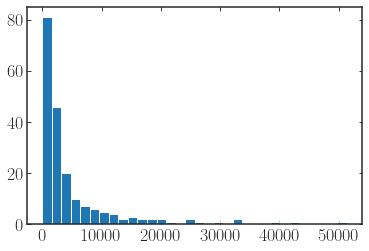

In [26]:
plt.hist(VOLUMESF110.flatten(), bins=32)

<AxesSubplot:ylabel='Frequency'>

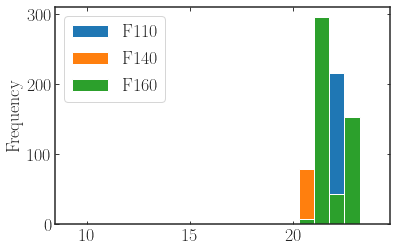

In [27]:
mag_f.plot(kind='hist', bins=20)

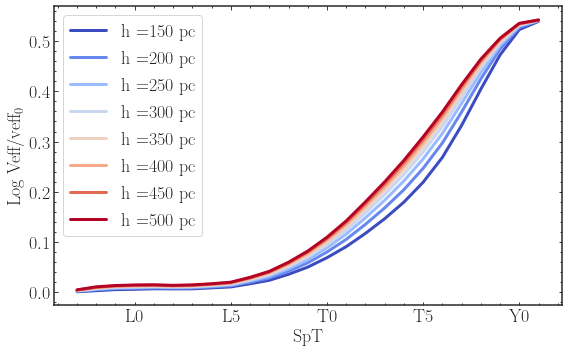

In [70]:
fig, ax=plt.subplots(figsize=(8, 5))
for idx, h in enumerate(wispsim.HS):
    #plt.plot(wispsim.SPGRID, np.log10(VOLUMESF110[idx]), color=cmap(cnorm(h/100)),
    #     label=r'h ={} pc'.format(h), linewidth=3, linestyle='-')
    
    plt.plot(wispsim.SPGRID, np.log10(VOLUMESF110[idx]/OLDERVOLUMES[idx]), color=cmap(cnorm(h/100)),
             linewidth=3, label=r'h ={} pc'.format(h), linestyle='-')

#plt.plot(wispsim.SPGRID, np.log10(vsunif), label=r'd$^3$' )
plt.ylabel(r'Log  Veff/veff$_0$', fontsize=18)
plt.xlabel('SpT', fontsize=18)
plt.legend(fontsize=18)

plt.minorticks_on()
#plt.grid(which='both')

plt.tight_layout()
ax.set_xticks([20, 25, 30, 35, 40])
ax.set_xticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])

plt.savefig(wisps.OUTPUT_FIGURES+'/simulation_volumes.pdf', bbox_inches='tight')

Text(0, 0.5, 'Normalized Number')

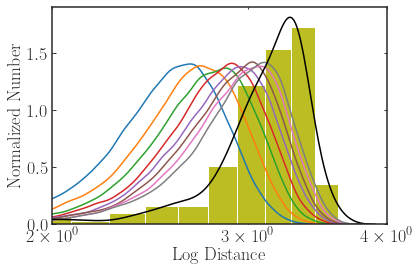

In [29]:
model='baraffe2003'
hidx=500
fig, ax=plt.subplots()
for hidx in wispsim.HS:
    cutdf=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(hidx)+'F110_corrected')
    cutdf=cutdf[cutdf.snr >= 3.]
    sns.kdeplot(cutdf.dist.apply(np.log10), label='simulated h= {} pc'.format(hidx), ax=ax)
    
cands=cands[cands.snr1 >=3.]
sns.kdeplot(cands.distance.apply(np.log10), label='observed', c='k')

plt.hist(wisps.drop_nan(cands.distance.apply(np.log10)), density=True)
#plt.legend()
ax.set_xlim([2, 4])
plt.xlabel('Log Distance')
plt.xscale('log')
plt.ylabel('Normalized Number')

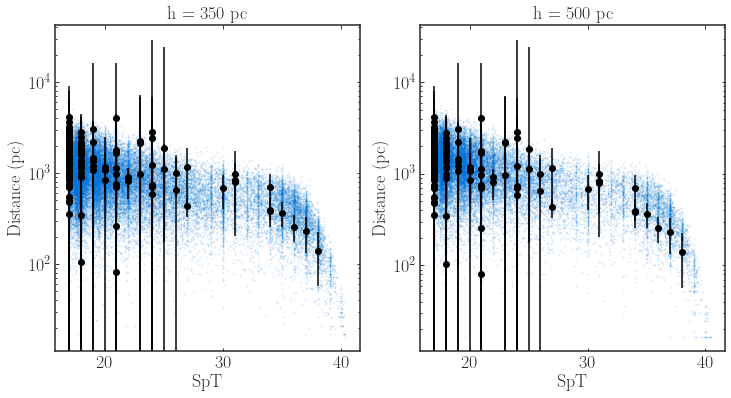

In [30]:
model='baraffe2003'
fig, ax=plt.subplots(ncols=2, figsize=(12, 6))
for idx, hidx in enumerate([350, 500]):
    cutdf=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(hidx)+'F110_corrected')
    cutdf=cutdf[cutdf.snr >= 3.]
    ax[idx].scatter(cutdf.spt, cutdf.dist, s=1., alpha=0.1, c='#0074D9')
    ax[idx].errorbar(cands.spt,cands.distance,  yerr= cands.distance_er, label='observed', c='k',  fmt='o', alpha=1.)
    ax[idx].set_yscale('log')
    ax[idx].set_ylabel('Distance (pc)')
    ax[idx].set_xlabel('SpT')
    ax[idx].set_title('h = {} pc'.format(hidx), fontsize=18)

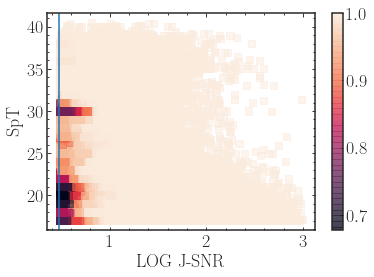

In [31]:
c=plt.scatter(cutdf.snr.apply(np.log10), cutdf.spt, s=50, alpha=0.5, marker=',', c=cutdf.slprob)
#is this binning a problem?
plt.xlabel('LOG J-SNR')
plt.ylabel('SpT')
plt.axvline(np.log10(3.))
plt.colorbar(c)
plt.minorticks_on()

In [81]:
wcands=cands[cands.grism_id.str.lower().str.startswith('par')]
hcands=cands[~cands.grism_id.str.lower().str.startswith('par')]

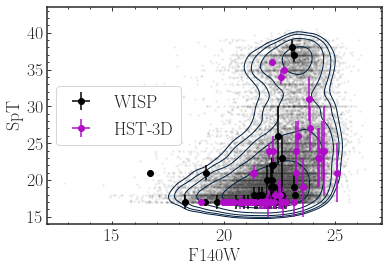

In [82]:
#sns.kdeplot(cutdf.appF140, cutdf.snr.apply(np.log10), s=50, marker=',', alpha=0.01)
#sns.kdeplot(cutdf.appF140, cutdf.snr.apply(np.log10),  fill=True)
sns.scatterplot(cutdf.appF140, cutdf.spt, s=5, color=".15", alpha=0.1)
#sns.histplot(x=cutdf.appF140, y=cutdf.snr.apply(np.log10), bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(cutdf.appF140, cutdf.spt, levels=np.flip(1-np.array([ 0.5, 0.75, 0.89, 0.94, 0.96])), 
            color="#001f3f", linewidths=1)

plt.errorbar(wcands.F140W, wcands.spt, xerr=wcands.F140W_er, yerr=wcands.spt_er, fmt='o', c='k', label='WISP')
plt.errorbar(hcands.F140W, hcands.spt, xerr=hcands.F140W_er, yerr=hcands.spt_er, fmt='o', c='#B10DC9', 
             label='HST-3D')


#is this binning a problem?
plt.xlabel('F140W')
plt.legend()
plt.ylabel('SpT')
plt.minorticks_on()
#plt.colorbar(c)

#plt.minorticks_on()

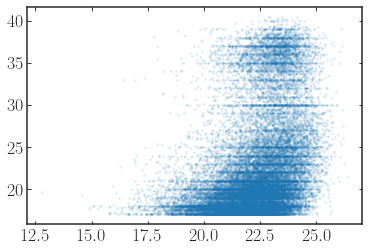

In [33]:
c=plt.scatter(cutdf.appF140, cutdf.spt, s=10,marker='.', alpha=0.1)

In [34]:
volumes=[]
dlimits=[]
for pnt in pnts140:
    vs=[]
    dls=[]
    for g in wispsim.SPGRID:
        vsx=[]
        for h in wispsim.HS:
            vsx.append((pnt.volumes[h])[g])
        dls.append(pnt.dist_limits[g])
        vs.append(vsx)
    volumes.append(vs)
    dlimits.append(dls)
volumes=np.array(volumes)
dlimits=np.array(dlimits)

steps=np.arange(533)
AREA=4.1*(u.arcmin**2).to(u.radian**2)

In [35]:
volumes.shape

(533, 25, 8)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


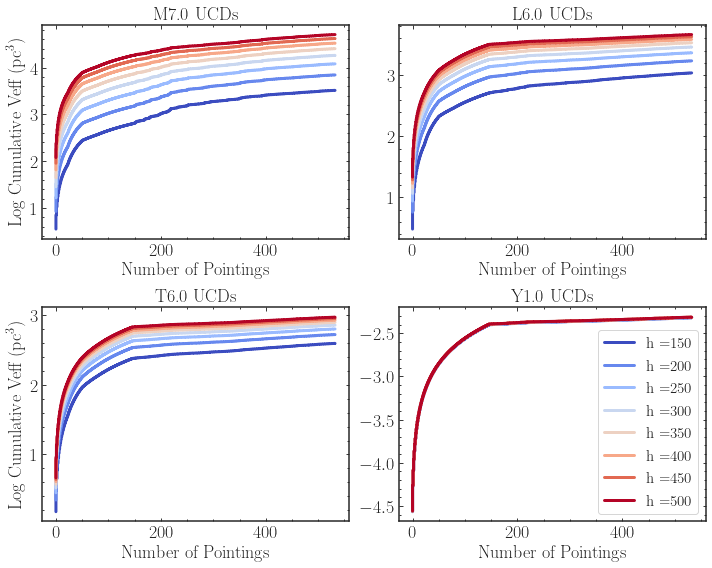

In [36]:
fig, ((ax, ax1), (ax2, ax3))=plt.subplots(figsize=(10, 8), ncols=2, nrows=2)
for idx, h in enumerate(wispsim.HS):
    ax.step(steps, np.log10(np.cumsum(volumes[:, 0, idx])*AREA), color=cmap(cnorm(h/100)), linewidth=3)
    ax1.step(steps, np.log10(np.cumsum(volumes[:, 9, idx])*AREA), color=cmap(cnorm(h/100)), linewidth=3)
    ax2.step(steps, np.log10(np.cumsum(volumes[:,-6 , idx])*AREA), color=cmap(cnorm(h/100)), linewidth=3)
    ax3.step(steps, np.log10(np.cumsum(volumes[:, -1, idx])*AREA), color=cmap(cnorm(h/100)), linewidth=3, label=r'h ={}'.format(h))


ax.set_ylabel(r'Log Cumulative Veff (pc$^3$)', fontsize=18)
ax2.set_ylabel(r'Log Cumulative Veff (pc$^3$)', fontsize=18)

for a in [ax, ax1, ax2, ax3]:
    a.set_xlabel('Number of Pointings', fontsize=18)
    a.minorticks_on()
    
ax.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[0])), fontsize=18)
ax1.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[9])), fontsize=18)
ax2.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[-6])), fontsize=18)
ax3.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[-1])), fontsize=18)

ax3.legend(fontsize=15)


plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/cumulative_volumes.pdf', bbox_inches='tight')

In [37]:
import numba

In [38]:
@numba.jit
def get_kde(r, z):
    kde=wisps.kernel_density([r, z])
    dens=kde.pdf([r, z])
    return dens

In [39]:
cutdf150=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(150)+'F140_corrected')
cutdf150['ra']=cutdf150.pnt.apply(lambda x: x.coord.ra)
cutdf150['dec']=cutdf150.pnt.apply(lambda x: x.coord.dec)
galc150=SkyCoord(ra=cutdf150['ra'].values, dec=cutdf150['dec'].values, distance= cutdf150.dist.values*u.pc)

cutdf400=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(400)+'F140_corrected')
cutdf400['ra']=cutdf400.pnt.apply(lambda x: x.coord.ra)
cutdf400['dec']=cutdf400.pnt.apply(lambda x: x.coord.dec)
galc400=SkyCoord(ra=cutdf400['ra'].values, dec=cutdf400['dec'].values, distance= cutdf400.dist.values*u.pc)

In [40]:
galoc0=galc150.transform_to(astrocoord.Galactocentric(galcen_distance=8.3*u.kpc))
x0, y0, z0=galoc0.cartesian.xyz

galoc1=galc400.transform_to(astrocoord.Galactocentric(galcen_distance=8.3*u.kpc))
x1, y1, z1=galoc1.cartesian.xyz

d0=(x0**2+y0**2+z0**2)**(0.5)
r0=(x0**2+y0**2)**(0.5)

d1=(x1**2+y1**2+z1**2)**(0.5)
r1=(x1**2+y1**2)**(0.5)


realcoords=SkyCoord(cands.coord.values)

galoc=realcoords.transform_to(astrocoord.Galactocentric(galcen_distance=8.3*u.kpc))
x, y, z=galoc.cartesian.xyz

r=(x**2+y**2)**0.5

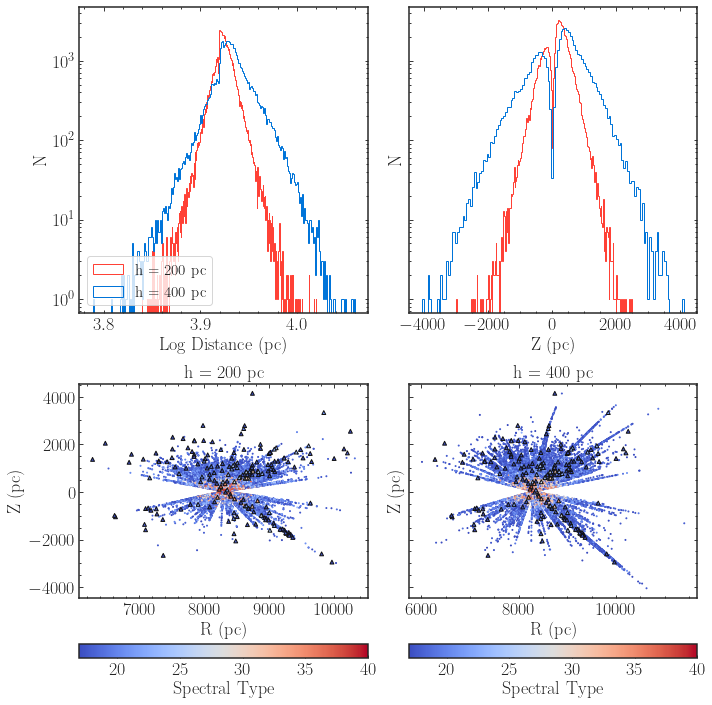

In [41]:
fig, (ax, ax1)=plt.subplots( figsize=(10, 10), ncols=2, nrows=2 , sharey='row')

h=ax[0].hist(np.log10(d0.flatten().value), color='#FF4136',
          bins='auto', histtype='step', label="h = 200 pc")

h=ax[0].hist(np.log10(d1.flatten().value),  color='#0074D9', bins='auto', 
          histtype='step', label="h = 400 pc")


h=ax[1].hist(z0.flatten().value, color='#FF4136',
          bins='auto', histtype='step', label="h = 200 pc")

h=ax[1].hist(z1.flatten().value,  color='#0074D9', bins='auto', 
          histtype='step', label="h = 400 pc")

c1=ax1[0].scatter(r0, z0, c=cutdf150.spt.values, vmin=17, vmax= 40, cmap='coolwarm', s=1)

ax1[0].set_title("h = 200 pc", fontsize=18)
ax1[1].set_title("h = 400 pc", fontsize=18)

c=ax1[1].scatter(r1, z1,s=1., c=cutdf400.spt.values,  vmin=17, vmax= 40, cmap='coolwarm')

cbar0=plt.colorbar(c, ax=ax1[1],    orientation='horizontal')
cbar1=plt.colorbar(c1, ax=ax1[0],    orientation='horizontal')

sc=ax1[1].scatter(r, z, c=cands.spt.values, s=15, cmap='coolwarm',  marker='^', edgecolors='#111111', 
                   vmin=17, vmax= 40, label='Real UCDs')
sc=ax1[0].scatter(r, z, c=cands.spt.values, s=15, cmap='coolwarm',  marker='^', edgecolors='#111111', 
                  vmin=17, vmax= 40,label='Real UCDs')

cbar0.ax.set_xlabel(r'Spectral Type', fontsize=18)
cbar1.ax.set_xlabel(r'Spectral Type', fontsize=18)
#cbar1.ax.set_xlabel(r'Log $ \rho/ \rho_0$ ', fontsize=18)

ax[0].legend(fontsize=15, loc='lower left')
ax[0].set_xlabel('Log Distance (pc)', fontsize=18)
ax[0].set_ylabel('N', fontsize=18)

ax[1].set_xlabel('Z (pc)', fontsize=18)
ax[1].set_ylabel('N', fontsize=18)
ax[1].set_yscale('log')

#ax1[0].legend(fontsize=15, loc='lower left')
ax1[0].set_xlabel('R (pc)', fontsize=18)
ax1[0].set_ylabel('Z (pc)', fontsize=18)

#ax1[1].legend(fontsize=15, loc='lower left')
ax1[1].set_xlabel('R (pc)', fontsize=18)
ax1[1].set_ylabel('Z (pc)', fontsize=18)


for a in np.concatenate([ax, ax1]):
    a.minorticks_on()
    
    
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/simulation_distances.jpeg', bbox_inches='tight', rasterized=True)

In [42]:
s=37
p=pnts[0]
faint_dict0={'F110W': [24.+1, 0.0], 'F140W': [24.+1, 0.0], 
    'F160W':[24.+1, 0.0]}
faint_dict1={'F110W': [24., 0.0], 'F140W': [24., 0.0], 
    'F160W':[24., 0.0]}
dmaxs=wisps.distance(faint_dict0, s, 0.0)
dmaxs1=wisps.distance(faint_dict1, s, 0.0)

d0=(np.nanmin([dmaxs['distF110W'],dmaxs['distF140W'], dmaxs['distF160W']]))
d1=(np.nanmin([dmaxs1['distF110W'],dmaxs1['distF140W'], dmaxs1['distF160W']]))


In [43]:
d0**3/d1**3

4.054753911906774

In [44]:
v0=wispsim.custom_volume(pnt.coord.galactic.l.radian, pnt.coord.galactic.b.radian, 1, d0, 300 )

v1=wispsim.custom_volume(pnt.coord.galactic.l.radian, pnt.coord.galactic.b.radian, 1, d1, 300 )

In [45]:
v1<v0, d1<d0

(True, True)

In [46]:
v0/v1

2.9744102941943384

In [47]:
corr_pols=wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections'] 

In [48]:
((corr_pols['F110W'])[0])(35)

0.6093985374240507

In [49]:
def less_than_fifty(row):
    ser={'lF110':False, 'lF140':False, 'lF160':False}
    if row.nF110 <50:
        ser['lF110']=True
    if row.nF140 <40:
        ser['lF140']=True
    if row.nF160 <50:
        ser['lF160']=True
    return pd.Series(ser)

maglimits=pd.DataFrame([x.mag_limits for x in pnts])
exposure_times=[np.nanmean(x.exposure_time) for x in pnts]
maglimits['pointing']=[x.name for x in pnts]
maglimits['survey']=[x.survey for x in pnts]
maglimits['exp']=np.log10(exposure_times)

nsrcs=pd.DataFrame([x.number_of_sources  for x in pnts])
number_of_sources=nsrcs.rename(columns={'F140': 'nF140', 'F160': 'nF160', 'F110':'nF110'})
less_than_df=number_of_sources.apply(less_than_fifty, axis=1)
number_of_sources['pointing']=[x.name for x in pnts]
number_of_sources=number_of_sources.join(less_than_df)


In [50]:
mag_lts_df=maglimits.merge(number_of_sources, on='pointing')

In [51]:
#magpolw=wispsim.MAG_LIMITS[survey][][0]
#magpolh=wispsim.MAG_LIMITS[survey][key][0]

#magsctt=MAG_LIMITS[survey][key][1]

#maglt=np.nanmean(np.random.normal(magpol(np.log10(pnt.exposure_time)), magsctt, 100))

In [52]:
mag_lts_df['survey']=mag_lts_df['survey'].str.upper()
mag_lts_df=mag_lts_df.rename(columns={"survey": 'SURVEY'})


In [53]:
import seaborn as sns

In [54]:
wisps_pnts=[x for x in pnts if x.name.startswith('par')]

In [55]:
hst3d_pnts=[x for x in pnts if not x.name.startswith('par')]

In [56]:
pols={'wisps':{}, 'hst3d':{}}

In [57]:
wisps.MAG_LIMITS

{'wisps': {'F110': (poly1d([ 1.58332072, 16.55679476]), 0.5038943667884174),
  'F140': (poly1d([ 1.55165028, 15.97456775]), 0.7495636144809823),
  'F160': (poly1d([ 0.32381253, 20.32498832]), 1.4165037712823727)},
 'hst3d': {'F110': (None, nan),
  'F140': (poly1d([ 0.3353958 , 21.64429535]), 0.18353856592257553),
  'F160': (poly1d([ 0.38991196, 21.33841198]), 0.1840187995673484)},
 'ncutoff': 50}

In [58]:
pnt_dicts={'wisps':wisps_pnts, 'hst3d':hst3d_pnts}

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


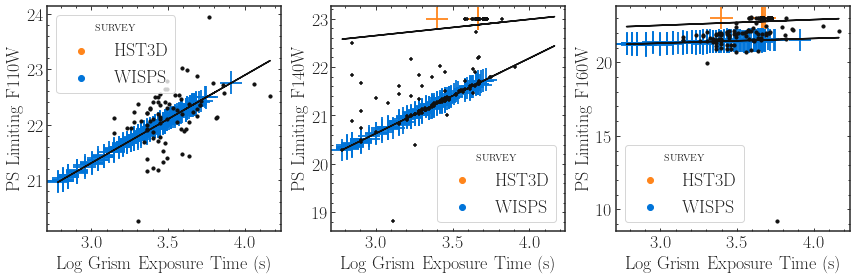

In [59]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))


sns.scatterplot(y='F110', x='exp', hue='SURVEY', s=500., ax=ax[0], palette=['#FF851B', '#0074D9'], 
                data=mag_lts_df[mag_lts_df.lF110], marker='+')

ax[0].scatter( mag_lts_df[~mag_lts_df.lF110]['exp'], mag_lts_df[~mag_lts_df.lF110]['F110'],s=10., 
              c='#111111')

sns.scatterplot(y='F140', x='exp', hue='SURVEY', s=500., ax=ax[1],palette=['#FF851B', '#0074D9'] , 
                data=mag_lts_df[mag_lts_df.lF140], marker='+')

ax[1].scatter(mag_lts_df[~mag_lts_df.lF140]['exp'], mag_lts_df[~mag_lts_df.lF140]['F140'],s=10., 
              c='#111111', marker='+')


sns.scatterplot(y='F160', x='exp', hue='SURVEY', s=500., ax=ax[2], palette=['#FF851B', '#0074D9'],
                data=mag_lts_df[mag_lts_df.lF160], marker='+')


ax[2].scatter(mag_lts_df[~mag_lts_df.lF160]['exp'], mag_lts_df[~mag_lts_df.lF160]['F160'], s=10., 
              c='#111111')

(ax[0]).plot(maglimits.exp,((wispsim.MAG_LIMITS['wisps'])['F110'][0])(maglimits.exp), c='#111111')
(ax[1]).plot(maglimits.exp,((wispsim.MAG_LIMITS['wisps'])['F140'][0])(maglimits.exp), c='#111111')
(ax[2]).plot(maglimits.exp,((wispsim.MAG_LIMITS['wisps'])['F160'][0])(maglimits.exp), c='#111111')



(ax[1]).plot(maglimits.exp,((wispsim.MAG_LIMITS['hst3d'])['F140'][0])(maglimits.exp), c='#111111')
(ax[2]).plot(maglimits.exp,((wispsim.MAG_LIMITS['hst3d'])['F160'][0])(maglimits.exp), c='#111111')


for a,k in zip(ax, maglimits.columns):
    #a.set_xlim([20, 25])
    #a.set_yscale('log')
    a.minorticks_on()
    a.set_ylabel('PS Limiting '+ k+'W', fontsize=18)
    a.set_xlabel('Log Grism Exposure Time (s)', fontsize=18)
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limit.pdf', bbox_inches='tight')

In [60]:
import scipy

In [61]:
def get_random_pointing(survey, key):
    pnts=[x for x in pnts110 if x.survey.startswith(survey)]
    p=pnts[np.random.randint(len(pnts))]
    vals=wisps.drop_nan(np.vstack(p.mags[key])[:,0])
    print (p)
    return p, vals

def draw_stuff(survey='wisp', key='F140'):
    p, vals=get_random_pointing(survey, key)
    while np.isnan(vals).all():
        p, vals=get_random_pointing(survey, key)
    return p, vals

21.034000000000002
22.95492247150396
24.450929985315923


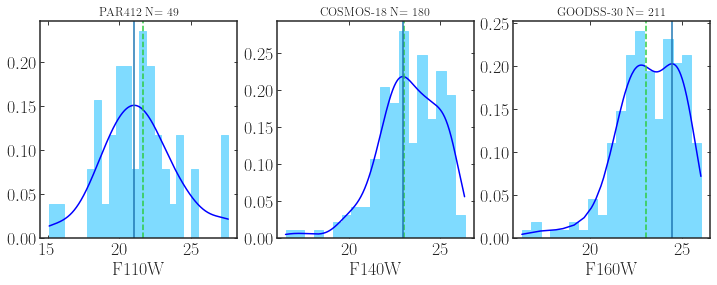

In [62]:
fig, ax=plt.subplots(figsize=(12, 4), ncols=3)

p0, vals0=draw_stuff(survey='wisp', key='F110')
vals0=wisps.drop_nan(vals0)
frq0, edges0=np.histogram(vals0, bins=int(np.ptp(vals0)/0.5), normed=True)
grid0=np.linspace(vals0.min(), vals0.max(),1000)
kde0=wisps.kernel_density(vals0).pdf(grid0)
ax[0].plot(grid0, kde0, c='b')
ax[0].bar(edges0[:-1], frq0, width=np.diff(edges0), align="edge", label='0.5 hist', color='#7FDBFF', 
        edgecolor='#7FDBFF', fill=True)
ax[0].axvline(p0.mag_limits['F110'], c='#2ECC40', linestyle='--', label='kde')
ax[0].axvline(wispsim.get_max_value(vals0))

p1, vals1=draw_stuff(survey='hst3d', key='F140')
vals1=wisps.drop_nan(vals1)
frq1, edges1=np.histogram(vals1, bins=int(np.ptp(vals1)/0.5), normed=True)
grid1=np.linspace(vals1.min(), vals1.max(),1000)
kde1=wisps.kernel_density(vals1).pdf(grid1)
ax[1].plot(grid1, kde1, c='b')
ax[1].bar(edges1[:-1], frq1, width=np.diff(edges1), align="edge", label='0.5 hist', color='#7FDBFF', 
        edgecolor='#7FDBFF', fill=True)
ax[1].axvline(p1.mag_limits['F140'], c='#2ECC40', linestyle='--', label='kde')
ax[1].axvline(wispsim.get_max_value(vals1))

p2, vals2=draw_stuff(survey='hst3d', key='F160')
vals2=wisps.drop_nan(vals2)
frq2, edges2=np.histogram(vals2, bins=int(np.ptp(vals2)/0.5), normed=True)
kde2=wisps.kernel_density(vals2).pdf(vals2)
ax[2].plot(vals2[np.argsort(vals2)], kde2[np.argsort(vals2)], c='b')
ax[2].bar(edges2[:-1], frq2, width=np.diff(edges2), align="edge", label='0.5 hist', color='#7FDBFF', 
        edgecolor='#7FDBFF', fill=True)
ax[2].axvline(p2.mag_limits['F160'], c='#2ECC40', linestyle='--', label='kde')
ax[2].axvline(wispsim.get_max_value(vals2))



ax[0].set_xlabel('F110W')
ax[0].set_title(p0.name.upper()+ ' N= {}'.format(len(vals0)))

ax[1].set_xlabel('F140W')
ax[1].set_title(p1.name.upper() + ' N= {}'.format(len(vals1)))

ax[2].set_xlabel('F160W')
ax[2].set_title(p2.name.upper() + ' N= {}'.format(len(vals2)))

plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limit_illustration.pdf')

In [63]:
big_file=wisps.get_big_file()

In [64]:
big_file=big_file[big_file.snr1>=3.0]

In [65]:
alls=wisps.drop_nan(np.vstack(big_file['F140'].values)[:,0])
strs=wisps.drop_nan(np.vstack(big_file[ (big_file.class_star !=0)]['F140'].values)[:,0])

In [66]:
kdes=scipy.stats.gaussian_kde(strs, bw_method='silverman').pdf(strs)

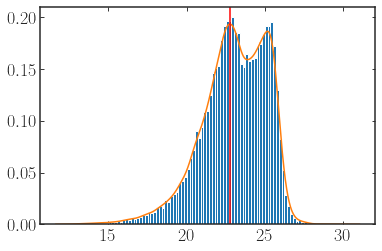

In [67]:
#plt.hist(alls,
#        bins=32, align='mid', density=True)
plt.hist(strs,
        bins='auto', align='mid', density=True)
#plt.axvline(p.mag_limits['F140'], c='k')
plt.plot(strs[np.argsort(strs)], kdes[np.argsort(strs)])
plt.axvline(strs[np.argmax(kdes)], c='r')

In [68]:
strs[np.argmax(kdes)]

22.780231854432543

In [69]:
scipy.stats.gaussian_kde?